In [1]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
SHOW_GIFS = True

# History

The fathers of Particle Swarm Optimization technique are considered James Kennedy and Russel Eberhart, who present them in their paper "Particle Swarm Optimization" in 1995 [[1]]([#Bibliography]). Authors take inspiration in nature, concretely in bird flocking and fish schooling and in their simulations already implemented in that time. We can see the behaviours in the videos bellow.

In [2]:
display.YouTubeVideo('0dskCpuxqtI?start=8', 560, 315)

In [3]:
display.YouTubeVideo('Y-5ffl5_7AI?start=90', 560, 315)

If you play watch through the second video, you can see one of the attempt to fully understand how the fish schooling really behaves by tracking each fish. Although not very important to us, I think it's still interesting.

Let's return to the topic. As scientists found out, the behavior of swarms is most of the time based on very simple rules, but executed in distributed manner. For example, when fish in the swarm see food, it will swim toward it. Otherwise, the fish keeps the same direction as its neighboors. As some wish change their direction toward the food, the rest of the swarm would follow them. As a result, the whole swarm reach the food and, in case there is no competetion between individuals (enough food for each one), each fish feed itself. 

Although there is no explicit communication, the simple rules provide simple information sharing ability inside the flock, increasing the total gain of the group as a whole.

The authors of the paper tried some approaches both to optimize given function and to simulate flock most "lifely". I will start simple and improve the idea further. 

# Particles

In [4]:
import numpy as np
import matplotlib.pylab as plt
import cocoex
import functools
import functions as fn
import execution as exe
import plotting as plot
import inspect
import strategies
import utils
from PIL import Image
import os
import functools

First of all, we will have a set of particles scattered over the parameter space. We can for example let them move randomly around.

In [5]:
definition = inspect.getsource(strategies.random_walk)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
def random_walk(particles: np.ndarray, *vars, stepsize: float = 0.2) -> np.ndarray:
    particles = particles  + np.random.normal(0, stepsize, particles.shape)
    return np.maximum(-5, np.minimum(5, particles))

```

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

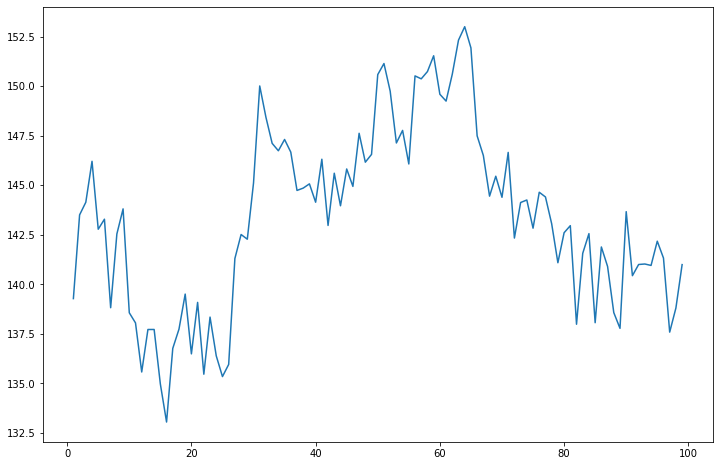

100% (99 of 99) |########################| Elapsed Time: 0:00:39 Time:  0:00:39


40747587

![img](main/1.gif)

In [6]:
with fn.get_suite_wrapper(dimension=[2], function_indices=[7]) as suite:
    for function in suite:
        populations, values = exe.execute(function, strategies.random_walk, show_progress=True)
        
        plt.figure(figsize=(12,8))
        plot.plot_graph(values, plot.popfn_mean())
        plt.show()
        
        if SHOW_GIFS:
            gif = plot.animate_movement(function, populations, show_progress=True)
            with open(os.path.join("main", f"001.gif"), "wb") as f:
                f.write(gif);
            display.Markdown(f"![img](main/001.gif)")

In Particle Swarm Optimization, the positions are not updated directly, instead, we assign each particle a velocity. Each iteration we modify the velocity and let the velocity determine the next position. Again, we may initialized the velocity uniformly and then update it randomly each iteration. 

Note that the velocity is the main reason, why we call the individuals particles, as velocity is usually connected with something with mass. Otherwise, we could call them just points or dots.

In [15]:
definition = inspect.getsource(strategies.RandomVelocity)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
class RandomVelocity:
    def __init__(self, lowerbound, upperbound, populationsize, dimension, velocity_lowerbound, velocity_upperbound):
        self.particles = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
        self.velocities = np.random.uniform(lowerbound, upperbound, (populationsize, dimension))
    def numpy(self):
        return self.particles
    def execute(self, *vars, stepsize: float =0.02):
        self.velocities = self.velocities + np.random.normal(0, stepsize, self.velocities.shape)
        self.particles = np.maximum(-5, np.minimum(5, self.particles + self.velocities))
        return self
    @staticmethod
    def init(lowerbound, upperbound, shape, velocity_lowerbound=0.1, velocity_upperbound=0.1):
        return RandomVelocity(lowerbound, upperbound, shape[0], shape[1], velocity_lowerbound, velocity_upperbound)

```

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

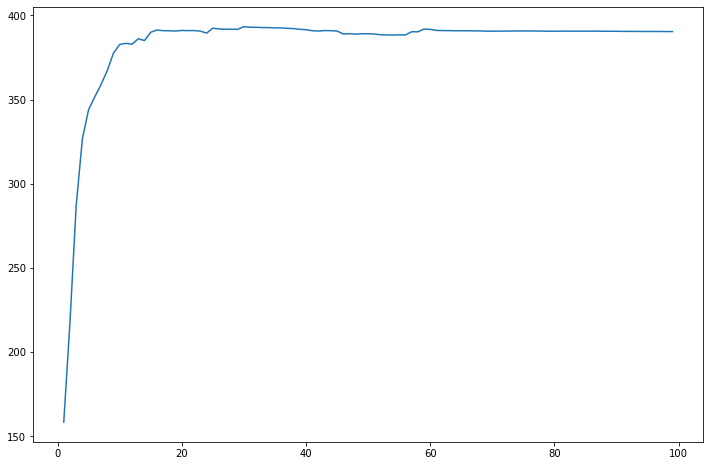

100% (99 of 99) |########################| Elapsed Time: 0:00:40 Time:  0:00:40


35022303

![img](main/002.gif)

In [14]:
with fn.get_suite_wrapper(dimension=[2], function_indices=[7]) as suite:
    for function in suite:
        populations, values = exe.execute(
            function, 
            strategies.RandomVelocity.execute, 
            initialization = strategies.RandomVelocity.init,
            show_progress=True)
        
        plt.figure(figsize=(12,8))
        plot.plot_graph(values, plot.popfn_mean())
        plt.show()
        
        if SHOW_GIFS:
            gif = plot.animate_movement(function, populations, show_progress=True)
            with open(os.path.join("main", f"002.gif"), "wb") as f:
                f.write(gif);
            display.Markdown(f"![img](main/002.gif)")

Note how the particles end up on the edge. Although I limit the position, so all particles stay within the area, it is not reflect in the in the velocity update. I will deal with it a bit later.

# Comparison - differencial evolution

Previous two examples were great to show the main principes, however, the results were not much satysfying. I wanted some algorithm, that I could compare algorithms with. I choose Differential evolution [[2]](#Bibliography), that was published around the same time (1996) and thus is a good candidate for comparison. Moreover, from my experience, differential evolution works quiet well for continuous optimization.

In the differential evolution, new individuals are based on the following formula.
$$
m_n = \text{Uniform}(p_3, p_0 + F \cdot (p_1 - p_2), CR)
$$

Terms $p_0, \dots, p_3$ are parents. Firstly, the algorithm adds difference of two parents and then performs uniform mutation with probability $1 - CR$. Moreover, I used parental tournament selection to pick up parents for the next iteration.

In [19]:
definition = inspect.getsource(strategies.differential_evolution)
display.display(display.Markdown(f'```python\n{definition}\n```'))

```python
def differential_evolution(population: np.ndarray, fitnesses: np.ndarray, function:cocoex.Problem,
                           parents_fraction: float = 0.6,
                           F: float = 0.8,
                           CR: float = 0.4,
                           ) -> np.ndarray:
    # pickup parents
    num_parents = int(len(population) * parents_fraction)
    parents_tournament_indices = np.random.randint(0, len(population), [2, num_parents])
    comparison = fitnesses[parents_tournament_indices[0]] < fitnesses[parents_tournament_indices[1]]
    better = np.concatenate([
        parents_tournament_indices[0, comparison],
        parents_tournament_indices[1, np.logical_not(comparison)]
    ])
    parents = population[better]

    # create children
    num_children = len(population) - num_parents
    picked_parents = np.random.randint(0, num_parents, [4, num_children])
    crossover_sample = np.random.random([num_children, function.dimension]) > CR
    mutated = parents[picked_parents[0], :] + F * (parents[picked_parents[1]] - parents[picked_parents[2]])
    mutated[crossover_sample] = parents[picked_parents[3]][crossover_sample]
    mutated = np.maximum(-5, np.minimum(5, mutated))

    return np.concatenate([
        parents,
        mutated
    ])

```

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 2D using differential evolution')

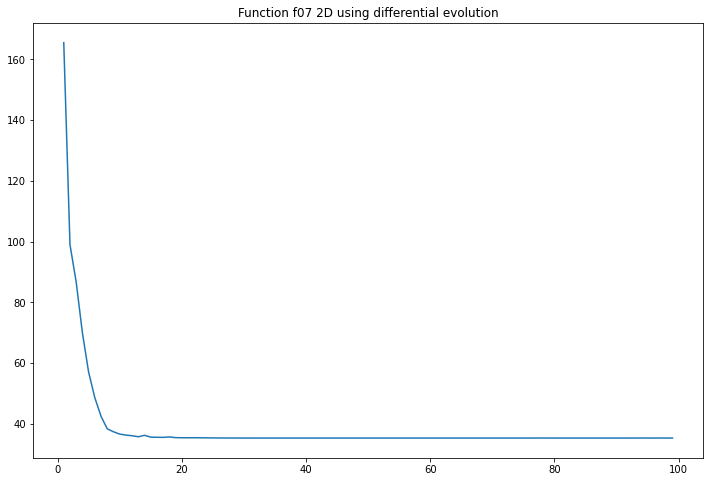

100% (99 of 99) |########################| Elapsed Time: 0:00:40 Time:  0:00:40


15517709

![img](main/003.gif)

Not found best solution
Best evaluation: 35.35383609492419


100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Function f07 5D using differential evolution')

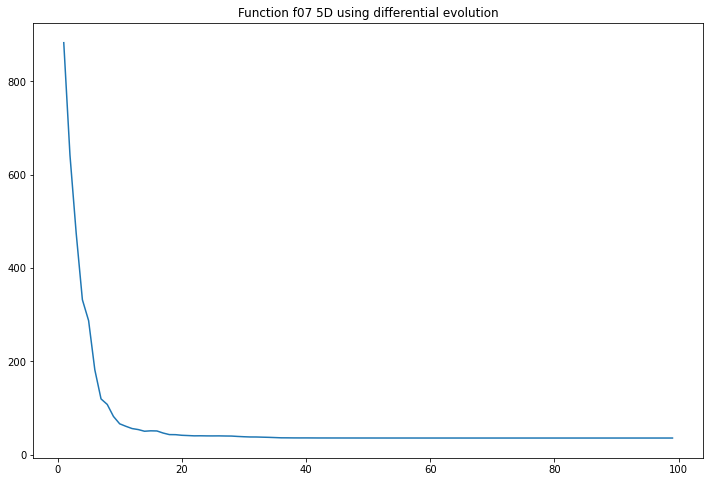

Not found best solution
Best evaluation: 35.40842248285676


In [23]:
with fn.get_suite_wrapper(dimension=[2, 5], function_indices=[7]) as suite:
    for function in suite:  # type: cocoex.Problem
        populations, values = exe.execute(
            function, 
            strategies.differential_evolution, 
            show_progress=True)

        plt.figure(figsize=(12,8))
        plot.plot_graph(values, plot.popfn_mean())
        plt.title(f"Function f07 {function.dimension}D using differential evolution")
        plt.show()
        
        if SHOW_GIFS and function.dimension == 2:
            gif = plot.animate_movement(function, populations, show_progress=True)
            with open(os.path.join("main", f"003.gif"), "wb") as f:
                f.write(gif);
            display.Markdown(f"![img](main/003.gif)")
            

        print(('Found' if function.final_target_hit else 'Not found') + " best solution", flush=True)
        print(f"Best evaluation: {function.best_observed_fvalue1}", flush=True)

As we can see, the algorithm is already doing something and although it doesn't find the optimal solution (that is $35.35$), it wasn't far away (the BBOB framework accepts solution around $10^{-9}$ of optimum). From now on, I will compare rest of the algorithms to this implementation of differential strategy.

# Taking best particle into account

# PSO 2006 - taking neighbors into account

# PSO 2011

# Bibliography

\[1\] J. Kennedy and R. Eberhart, "Particle swarm optimization," Proceedings of ICNN'95 - International Conference on Neural Networks, Perth, WA, Australia, 1995, pp. 1942-1948 vol.4.

\[2 \] R. Storn, "On the usage of differential evolution for function optimization," Proceedings of North American Fuzzy Information Processing, Berkeley, CA, USA, 1996, pp. 519-523.
